In [1]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import os, glob, re, random, time
from functools import partial
from pathlib import Path
import imageio
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import cmp_to_key

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from sklearn.metrics import roc_auc_score

In [2]:
class Config():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists(), f'{base_path} does not exist'
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    png_folder = 'png'
    num_images = 32
    size = 256
    seed = 42
    test_size = 0.1
    clahe = False
    batch_size = 4
    num_workers = 7
    lr = 1e-3
    epochs = 20
    extra_check_epochs = [8]
    check_frequency = 4
    
cfg = Config()

### Function for loading images

In [3]:
def load_dicom(path):
    # read file
    dicom = pydicom.read_file(path)
    # get pixel data into a useful format. 
    data = dicom.pixel_array
    # transform data into black and white scale / grayscale
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def convert_dicom_to_png(path, png_image_path, resize = None, threshold=10):
    dicom = pydicom.read_file(path)
    data = apply_voi_lut(dicom.pixel_array, dicom)
    # If Resize == True, Resize Image to Specified Resolution
    if resize:
        data = cv2.resize(data, resize)
    # Transform Data as Necessary     
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    if np.mean(data) <= threshold:
        return 0
    # SAVE PNG TO DISK     
    imageio.imsave(png_image_path, data)
    return 1

### Loading data frames

In [4]:
train_df = pd.read_csv(cfg.base_path/'train_labels.csv')
train_df = train_df.drop(train_df[train_df['BraTS21ID'].isin([109, 123, 709])].index)
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [5]:
def convert_all_dicom_to_png(df, mri_type = 'FLAIR', image_path = 'train'):
    min_conversions = np.inf
    for scan_id in tqdm(df['BraTS21ID'], total=len(df)):
        dir_name = str(scan_id).zfill(5)
        png_dir = cfg.base_path/cfg.png_folder/image_path/dir_name/mri_type
        if not png_dir.exists():
            png_dir.mkdir(parents=True)
        source_dir = ((cfg.base_path/image_path)/dir_name)
        assert source_dir.exists()
        files = glob.glob(f"{str(source_dir/mri_type)}/*.dcm")
        print(f'Processing {png_dir}')
        conversions_sum = 0
        for f in files:
            f_name = re.sub(r'.+/(.+)\.dcm', r'\1.png', f)
            png_file = png_dir/f_name
            conversions_sum += convert_dicom_to_png(f, png_file, resize=(256,256))
        if min_conversions > conversions_sum:
            min_conversions = conversions_sum
            print('Min conversion', min_conversions)
    return min_conversions

In [6]:
submission_df = pd.read_csv(cfg.base_path/'sample_submission.csv')
submission_df

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


## Transform to png
Comment out if not needed

In [7]:
!rm -rf {cfg.base_path/cfg.png_folder}
if not (cfg.base_path/cfg.png_folder).exists():
    os.mkdir(cfg.base_path/cfg.png_folder)
convert_all_dicom_to_png(train_df, mri_type='FLAIR', image_path='train')

In [9]:
convert_all_dicom_to_png(submission_df, mri_type='FLAIR', image_path='test')

Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00001/FLAIR
Min conversion 125
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00013/FLAIR
Min conversion 60
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00015/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00027/FLAIR
Min conversion 56
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00037/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00047/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00079/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00080/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00082/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00091/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00114/FLAIR
Min conversion 16
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00119/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00125/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/0

15

In [10]:
!cp -R {cfg.base_path}/png/test/00013 {cfg.base_path}/png/train/00013
!cp -R {cfg.base_path}/png/test/00001 {cfg.base_path}/png/train/00001

### Load PNGs

In [11]:
def read_png(path):
    return mpimg.imread(path)

def convert_path_to_int(x):
    res = int(re.sub(r'.+\-+(\d+)\..+', r'\1', x))
    return res

def load_png_images_3d(scan_id, num_imgs=cfg.num_images, img_size=cfg.size, mri_type="FLAIR", split="train", clahe=False):

    glob_expr = f'{cfg.base_path}/png/{split}/{scan_id}/{mri_type}/*.png'
    files = glob.glob(glob_expr)
    files.sort(key=cmp_to_key(lambda x, y: -1 if convert_path_to_int(x) < convert_path_to_int(y) else 1))
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    try:
        img3d = np.stack([read_png(f) for f in files[p1:p2]]).T 
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d,  n_zero), axis = -1)
    except Exception as e:
        print(f'Error on glob expression', glob_expr)
        raise e
            
    return np.expand_dims(img3d,0)

(-0.5, 255.5, 255.5, -0.5)

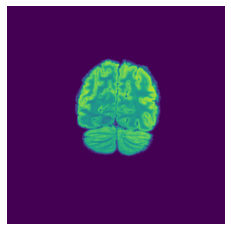

In [12]:
sample_img = read_png(cfg.base_path/'png/train/00000/FLAIR/Image-100.png')
plt.imshow(sample_img)
plt.axis('off')

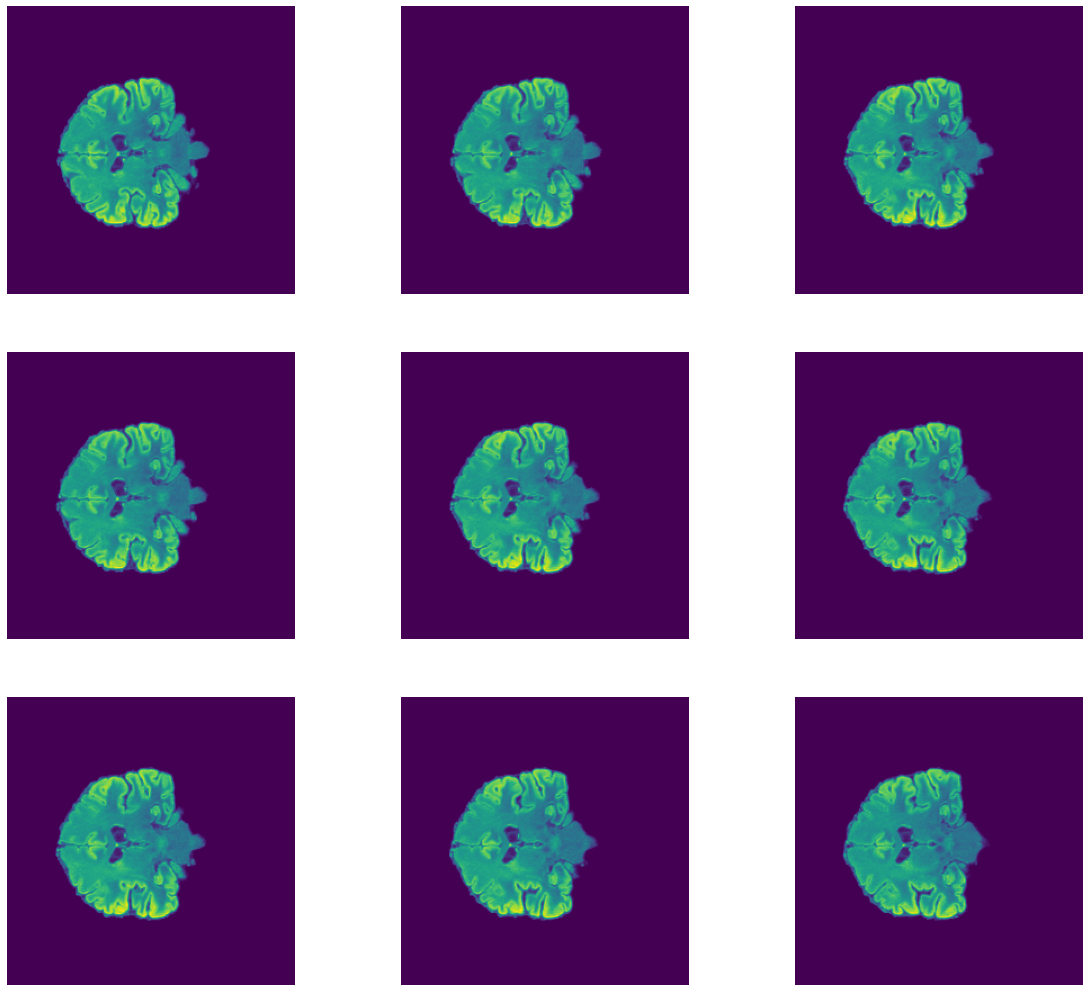

In [13]:
sample_images = load_png_images_3d('00000').squeeze()
f, axarr = plt.subplots(3, 3, figsize=(20, 18))
for r in range(3):
    for c in range(3):
        axarr[r, c].imshow(sample_images[:,:,r * 2 + c * 2])
        axarr[r, c].axis('off')

### Seeding

In [14]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### Train / Test Split

In [15]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=cfg.test_size, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [16]:
len(df_valid) / len(df_train)

0.11281070745697896

In [17]:
df_valid = df_valid.append(pd.DataFrame([{'BraTS21ID': 1, 'MGMT_value': 1}, {'BraTS21ID': 13, 'MGMT_value': 1}]))

In [18]:
len(df_valid) / len(df_train)

0.11663479923518165

### Dataset

In [19]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        mri_type = self.mri_type[index]
        if self.targets is None:
            data = load_png_images_3d(str(scan_id).zfill(5), mri_type=mri_type, split=self.split, clahe=cfg.clahe)
        else:
            data = load_png_images_3d(str(scan_id).zfill(5), mri_type=mri_type, split="train", clahe=cfg.clahe)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [20]:
df_train.loc[:,"MRI_Type"] = 'FLAIR'
sample_ds = Dataset(df_train['BraTS21ID'], df_train['MGMT_value'], df_train['MRI_Type'])

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
sample_ds[0]['X'].shape

torch.Size([1, 256, 256, 32])

### Model

In [22]:
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

In [23]:
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class SimpleBlock(nn.Module):
    
    def __init__(self, in_planes, out_planes, drop=None):
        super().__init__()
        self.conv = conv3x3x3(in_planes, out_planes, stride=1)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool3d(kernel_size=2)
        self.bn = nn.BatchNorm3d(out_planes)
        if drop != None:
            self.drop = nn.Dropout(drop)
        else:
            self.drop = None
        
    def forward(self, x):
        x = self.bn(self.maxpool(self.relu(self.conv(x))))
        if self.drop != None:
            x = self.drop(x)
        return x

class CustomModel(nn.Module):

    def __init__(self):
        super().__init__()
        in_planes = 1
        out_planes = 32
        self.block1 = SimpleBlock(1, 64)
        self.block2 = SimpleBlock(64, 128, drop=0.02)
        self.block3 = SimpleBlock(128, 256, drop=0.03)
#         self.block4 = SimpleBlock(256, 512, drop=0.04)
        self.avg = nn.AdaptiveAvgPool3d((4, 1, 1))
        self.fc = nn.Linear(1024, 1024)
        self.relu = nn.ReLU()
        self.regressor = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
#         x = self.block4(x)
        x = self.avg(x).view(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.regressor(x)
        x = torch.sigmoid(x)
        return x

In [24]:
m = nn.AdaptiveAvgPool3d((2,1,1))
a = torch.randn([4, 512, 4, 16, 16])
m(a).shape

torch.Size([4, 512, 2, 1, 1])

In [25]:
def create_model():
    model = CustomModel()
    model.to(cfg.device)
    return model

In [26]:
# sample_model = CustomModel()
# sample_model.to(cfg.device)
# torch.backends.cudnn.enabled = False
# sample_data = torch.randn([4, 1, 64, 256, 256]).to(cfg.device)
# sample_model(sample_data).shape

### Trainer

In [27]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = -np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
#         self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader) / 2), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lr_sched = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            train_loss, train_time = self.train_epoch(train_loader, valid_loader, n_epoch, save_path)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
            self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
        
    def check_and_save(self, valid_loss, valid_auc, valid_time, n_epoch, save_path):
        # if True:
        # if self.best_valid_score < valid_auc: 
        if self.best_valid_score < valid_auc and valid_auc > 0.5: 
            self.save_model(n_epoch, save_path, valid_loss, valid_auc)
            self.info_message(
                 "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                self.best_valid_score, valid_loss, self.lastmodel
            )
            self.best_valid_score = valid_auc
            self.n_patience = 0
        else:
            self.n_patience += 1
            
    def print_valid_message(self, valid_loss, valid_auc, valid_time, n_epoch):
        self.info_message(
            "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
            n_epoch, valid_loss, valid_auc, valid_time
        )
            
    def train_epoch(self, train_loader, valid_loader, n_epoch, save_path):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        scaler = torch.cuda.amp.GradScaler() # fp16
        for step, batch in tbar:
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                
#             loss.backward()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

            sum_loss += loss.detach().item()
#             torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
#             self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
            if n_epoch in cfg.extra_check_epochs:
                if step % cfg.check_frequency == 0:
                    valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                    self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
                    self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = torch.sigmoid(self.model(X).squeeze(1))
                loss = self.criterion(outputs, targets)
                print('outputs', outputs.mean().item(), outputs.std().item())
                print('targets', targets.mean().item(), targets.std().item())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [28]:
def loss_func(input, target):
#     return F.binary_cross_entropy_with_logits(input, target) * 0.5 + F.mse_loss(input, target) * 0.5
#     return F.binary_cross_entropy_with_logits(input, target) * 0.2 + dice_loss(input, target) * 0.8
    return F.binary_cross_entropy_with_logits(input, target)

In [29]:
def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = create_model()

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = loss_func

    trainer = Trainer(
        model, 
        cfg.device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs + 100,
    )
    
    return trainer.lastmodel

In [30]:
!rm -rf {str(cfg.models_path)}/*.pth

(523, 3) (61, 3)


,BraTS21ID,MGMT_value,MRI_Type
549,803,0,FLAIR
353,520,1,FLAIR
272,399,0,FLAIR
137,206,0,FLAIR
292,423,0,FLAIR


EPOCH: 1


Train Step 131/131, train_loss: 0.6958


outputs 0.5518558025360107 0.04138527438044548
targets 0.5 0.5658032894134521
outputs 0.6089212894439697 0.006986353080719709
targets 0.5 0.5658032894134521
outputs 0.5916014909744263 0.037967436015605927
targets 0.7450000047683716 0.49000000953674316
outputs 0.5105451941490173 0.009417681023478508
targets 0.5 0.5658032894134521
outputs 0.5875482559204102 0.04115379601716995
targets 0.7450000047683716 0.49000000953674316
outputs 0.5285516977310181 0.025595322251319885
targets 0.2549999952316284 0.49000000953674316
outputs 0.5669161677360535 0.06923791021108627
targets 0.5 0.5658032894134521
outputs 0.5892068147659302 0.05087981000542641
targets 0.7450000047683716 0.49000000953674316
outputs 0.5877606868743896 0.04600667208433151
targets 0.5 0.5658032894134521
outputs 0.5429596304893494 0.05927349627017975
targets 0.2549999952316284 0.49000000953674316
outputs 0.5809104442596436 0.04022100195288658
targets 0.2549999952316284 0.49000000953674316
outputs 0.5890165567398071 0.0558935999870

Train Step 131/131, train_loss: 0.6879


outputs 0.5000024437904358 3.380166845090571e-06
targets 0.5 0.5658032894134521
outputs 0.5000649690628052 0.00010169093729928136
targets 0.5 0.5658032894134521
outputs 0.5000067949295044 6.445345206884667e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 2.4333495218797907e-083
targets 0.5 0.5658032894134521
outputs 0.500002920627594 3.4290376333956374e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000019073486328 2.4799878701742273e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.500469446182251 0.0009306653519161046
targets 0.5 0.5658032894134521
outputs 0.5000637769699097 6.0975558881182224e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500016450881958 2.4207252863561735e-05
targets 0.5 0.5658032894134521
outputs 0.5000668168067932 0.0001310770312556997
targets 0.2549999952316284 0.49000000953674316
outputs 0.500002920627594 3.470829824436805e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000269412994385 4.9478472

Train Step 131/131, train_loss: 0.6931


outputs 0.5005434155464172 0.0007658966351300478
targets 0.5 0.5658032894134521
outputs 0.5024753212928772 0.0033903075382113457
targets 0.5 0.5658032894134521
outputs 0.5006736516952515 0.00046437059063464403
targets 0.7450000047683716 0.49000000953674316
outputs 0.500029444694519 3.4823347959900275e-05
targets 0.5 0.5658032894134521
outputs 0.5002871155738831 0.00022891098342370242
targets 0.7450000047683716 0.49000000953674316
outputs 0.5004949569702148 0.0005693298880942166
targets 0.2549999952316284 0.49000000953674316
outputs 0.5060694813728333 0.0116255022585392
targets 0.5 0.5658032894134521
outputs 0.5023151636123657 0.0019470457918941975
targets 0.7450000047683716 0.49000000953674316
outputs 0.500792384147644 0.0008314884616993368
targets 0.5 0.5658032894134521
outputs 0.5018680691719055 0.0023978736717253923
targets 0.2549999952316284 0.49000000953674316
outputs 0.5003700256347656 0.0003763908171094954
targets 0.2549999952316284 0.49000000953674316
outputs 0.5009025931358337

Train Step 131/131, train_loss: 0.6920


outputs 0.5000241994857788 2.6826406610780396e-05
targets 0.5 0.5658032894134521
outputs 0.5000840425491333 5.036577567807399e-05
targets 0.5 0.5658032894134521
outputs 0.5000857710838318 0.00012866857287008315
targets 0.7450000047683716 0.49000000953674316
outputs 0.500001072883606 1.2880673239124008e-06
targets 0.5 0.5658032894134521
outputs 0.5000725984573364 6.082719482947141e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000859498977661 0.00015609005640726537
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000952482223511 0.00011105660087196156
targets 0.5 0.5658032894134521
outputs 0.500108003616333 8.71008014655672e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000878572463989 6.324885180220008e-05
targets 0.5 0.5658032894134521
outputs 0.5000494718551636 9.408015466760844e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000854730606079 9.714431507745758e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500066280364

Train Step 131/131, train_loss: 0.6931


outputs 0.5000414848327637 4.3908967199968174e-05
targets 0.5 0.5658032894134521
outputs 0.5001310110092163 8.579945279052481e-05
targets 0.5 0.5658032894134521
outputs 0.5001202821731567 0.00016176114149857312
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000019669532776 2.3086060991772683e-06
targets 0.5 0.5658032894134521
outputs 0.5001147985458374 7.913557783467695e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500106155872345 0.00018506721244193614
targets 0.2549999952316284 0.49000000953674316
outputs 0.500123143196106 0.00014174914394970983
targets 0.5 0.5658032894134521
outputs 0.5001599192619324 0.00012376703671179712
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001400113105774 9.005529136629775e-05
targets 0.5 0.5658032894134521
outputs 0.5000680088996887 0.00012694511679001153
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001389980316162 0.0001498372876085341
targets 0.2549999952316284 0.49000000953674316
outputs 0.500107705

Train Step 131/131, train_loss: 0.6932


outputs 0.5000361204147339 3.941011891583912e-05
targets 0.5 0.5658032894134521
outputs 0.5001139044761658 7.288598135346547e-05
targets 0.5 0.5658032894134521
outputs 0.5000752210617065 8.619594154879451e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000020861625671 2.4452438083244488e-06
targets 0.5 0.5658032894134521
outputs 0.5000907182693481 5.5569613323314115e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000717639923096 0.00012238157796673477
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000852346420288 9.773748024599627e-05
targets 0.5 0.5658032894134521
outputs 0.500114381313324 8.491454354953021e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001130700111389 6.662544910795987e-05
targets 0.5 0.5658032894134521
outputs 0.5000468492507935 8.473566413158551e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001111030578613 0.00010672789358068258
targets 0.2549999952316284 0.49000000953674316
outputs 0.50008153915

Train Step 131/131, train_loss: 0.6932


outputs 0.5000828504562378 9.946869977284223e-05
targets 0.5 0.5658032894134521
outputs 0.5003033876419067 0.00017468526493757963
targets 0.5 0.5658032894134521
outputs 0.5001589059829712 0.00015309137233998626
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000014305114746 1.7305887922702823e-06
targets 0.5 0.5658032894134521
outputs 0.500220537185669 0.00014801819634158164
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001093745231628 0.00016717093240004033
targets 0.2549999952316284 0.49000000953674316
outputs 0.5002392530441284 0.00028134422609582543
targets 0.5 0.5658032894134521
outputs 0.5003068447113037 0.0002240815374534577
targets 0.7450000047683716 0.49000000953674316
outputs 0.5002874135971069 0.00019170904124621302
targets 0.5 0.5658032894134521
outputs 0.5001199245452881 0.00022965326206758618
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001952052116394 0.00013753309031017125
targets 0.2549999952316284 0.49000000953674316
outputs 0.500213

outputs 0.5000572204589844 7.089599967002869e-05
targets 0.5 0.5658032894134521
outputs 0.5001970529556274 0.00011542758875293657
targets 0.5 0.5658032894134521
outputs 0.5000939965248108 8.57466584420763e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000012516975403 1.4938863159841276e-06
targets 0.5 0.5658032894134521
outputs 0.5001364350318909 9.172257705358788e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000736713409424 0.00011405234545236453
targets 0.2549999952316284 0.49000000953674316
outputs 0.500148594379425 0.00017516044317744672
targets 0.5 0.5658032894134521
outputs 0.5001899600028992 0.0001380381581839174
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001822710037231 0.00011996242392342538
targets 0.5 0.5658032894134521
outputs 0.5000738501548767 0.00013953741290606558
targets 0.2549999952316284 0.49000000953674316
outputs 0.500124990940094 8.735025039641187e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50013041496

outputs 0.5000343918800354 4.5386168494587764e-05
targets 0.5 0.5658032894134521
outputs 0.5001147389411926 7.018505857558921e-05
targets 0.5 0.5658032894134521
outputs 0.5000496506690979 4.415854346007109e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.348197297891602e-07
targets 0.5 0.5658032894134521
outputs 0.5000751614570618 5.0841059419326484e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000432133674622 6.744911661371589e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000832080841064 9.891059744404629e-05
targets 0.5 0.5658032894134521
outputs 0.5001059770584106 7.689047924941406e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001037120819092 6.828505138400942e-05
targets 0.5 0.5658032894134521
outputs 0.5000403523445129 7.587663276353851e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000706315040588 4.986836211173795e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500071883201

outputs 0.5000292062759399 3.941384420613758e-05
targets 0.5 0.5658032894134521
outputs 0.500097393989563 6.070497693144716e-05
targets 0.5 0.5658032894134521
outputs 0.5000403523445129 3.5464545362628996e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000005960464478 6.561024861184706e-07
targets 0.5 0.5658032894134521
outputs 0.5000623464584351 4.269829878467135e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.50003582239151 5.587991836364381e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000701546669006 8.365024405065924e-05
targets 0.5 0.5658032894134521
outputs 0.5000890493392944 6.459223368437961e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000873804092407 5.7786961406236514e-05
targets 0.5 0.5658032894134521
outputs 0.5000336170196533 6.330167525447905e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000580549240112 4.0890856325859204e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50005996227264

outputs 0.5000386238098145 5.1087648898828775e-05
targets 0.5 0.5658032894134521
outputs 0.5001354813575745 8.27185795060359e-05
targets 0.5 0.5658032894134521
outputs 0.5000571608543396 4.9739341193344444e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000005960464478 7.484280217795458e-07
targets 0.5 0.5658032894134521
outputs 0.5000880360603333 6.17599071119912e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500045657157898 6.978534656809643e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001007318496704 0.00011996646935585886
targets 0.5 0.5658032894134521
outputs 0.5001280307769775 9.294143092120066e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500123143196106 8.254962449427694e-05
targets 0.5 0.5658032894134521
outputs 0.5000483989715576 9.238313941750675e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000767111778259 5.270921246847138e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500086486339569

outputs 0.5000434517860413 5.664854688802734e-05
targets 0.5 0.5658032894134521
outputs 0.5001548528671265 9.346171282231808e-05
targets 0.5 0.5658032894134521
outputs 0.5000666379928589 5.7911798649001867e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000006556510925 7.817075697857945e-07
targets 0.5 0.5658032894134521
outputs 0.5001012086868286 7.106431439751759e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000509023666382 7.69292819313705e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001163482666016 0.00013856856094207615
targets 0.5 0.5658032894134521
outputs 0.5001477003097534 0.00010712462972151116
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001411437988281 9.514050179859623e-05
targets 0.5 0.5658032894134521
outputs 0.5000558495521545 0.00010684801964089274
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000861883163452 5.881255492568016e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50010037422

outputs 0.5000475645065308 6.128459062892944e-05
targets 0.5 0.5658032894134521
outputs 0.500170111656189 0.0001016003661789
targets 0.5 0.5658032894134521
outputs 0.5000742673873901 6.415371899493039e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.485379794365144e-07
targets 0.5 0.5658032894134521
outputs 0.5001115798950195 7.827508670743555e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000551342964172 8.258791058324277e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001281499862671 0.00015264131070580333
targets 0.5 0.5658032894134521
outputs 0.5001629590988159 0.00011802052904386073
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001553297042847 0.00010485406528459862
targets 0.5 0.5658032894134521
outputs 0.5000616312026978 0.00011805605026893318
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000940561294556 6.392035720637068e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50011116266250

outputs 0.500058650970459 7.296568946912885e-05
targets 0.5 0.5658032894134521
outputs 0.5002230405807495 0.00013210375618655235
targets 0.5 0.5658032894134521
outputs 0.5000988245010376 8.494700159644708e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000008344650269 9.408601613358769e-07
targets 0.5 0.5658032894134521
outputs 0.5001469850540161 0.00010577632929198444
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000659227371216 9.737890650285408e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001739263534546 0.00020741713524330407
targets 0.5 0.5658032894134521
outputs 0.5002199411392212 0.00015924179751891643
targets 0.7450000047683716 0.49000000953674316
outputs 0.5002060532569885 0.0001411807315889746
targets 0.5 0.5658032894134521
outputs 0.500083327293396 0.0001608067686902359
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001175999641418 7.93366925790906e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001502633094

outputs 0.5000755190849304 8.989850903162733e-05
targets 0.5 0.5658032894134521
outputs 0.5002926588058472 0.0001678681292105466
targets 0.5 0.5658032894134521
outputs 0.5001344084739685 0.00011353101581335068
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000010132789612 1.2005071994281025e-06
targets 0.5 0.5658032894134521
outputs 0.5001957416534424 0.00014187017222866416
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000824928283691 0.00011965811427216977
targets 0.2549999952316284 0.49000000953674316
outputs 0.5002341270446777 0.00027915145619772375
targets 0.5 0.5658032894134521
outputs 0.5002954602241516 0.00021334606572054327
targets 0.7450000047683716 0.49000000953674316
outputs 0.5002729892730713 0.00018849500338546932
targets 0.5 0.5658032894134521
outputs 0.5001122355461121 0.00021722061501350254
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001506209373474 0.00010114978795172647
targets 0.2549999952316284 0.49000000953674316
outputs 0.50020

outputs 0.5001202821731567 0.0001318691356573254
targets 0.5 0.5658032894134521
outputs 0.5004714131355286 0.00025360312429256737
targets 0.5 0.5658032894134521
outputs 0.5002322196960449 0.00018856704991776496
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000016093254089 1.8660791738511762e-06
targets 0.5 0.5658032894134521
outputs 0.5003234148025513 0.00023919239174574614
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001223087310791 0.00017132892389781773
targets 0.2549999952316284 0.49000000953674316
outputs 0.5003975629806519 0.00047354184789583087
targets 0.5 0.5658032894134521
outputs 0.5004976987838745 0.00035794591531157494
targets 0.7450000047683716 0.49000000953674316
outputs 0.5004465579986572 0.0003140089684166014
targets 0.5 0.5658032894134521
outputs 0.5001910924911499 0.0003713174082804471
targets 0.2549999952316284 0.49000000953674316
outputs 0.5002323389053345 0.00015687738778069615
targets 0.2549999952316284 0.49000000953674316
outputs 0.500345

outputs 0.500184953212738 0.0001887891412479803
targets 0.5 0.5658032894134521
outputs 0.5007660388946533 0.00038784826756455004
targets 0.5 0.5658032894134521
outputs 0.5003936290740967 0.00029866682598367333
targets 0.7450000047683716 0.49000000953674316
outputs 0.500001847743988 2.150453155991272e-06
targets 0.5 0.5658032894134521
outputs 0.500520646572113 0.00043623600504361093
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001533031463623 0.000204166179173626
targets 0.2549999952316284 0.49000000953674316
outputs 0.5007592439651489 0.0009143755305558443
targets 0.5 0.5658032894134521
outputs 0.5008944869041443 0.0006483890465460718
targets 0.7450000047683716 0.49000000953674316
outputs 0.500746488571167 0.0005697122542187572
targets 0.5 0.5658032894134521
outputs 0.5003571510314941 0.0007019582553766668
targets 0.2549999952316284 0.49000000953674316
outputs 0.5003232955932617 0.00024127979122567922
targets 0.2549999952316284 0.49000000953674316
outputs 0.500605821609497

outputs 0.5002960562705994 0.0002999340940732509
targets 0.5 0.5658032894134521
outputs 0.5011665225028992 0.0005649678059853613
targets 0.5 0.5658032894134521
outputs 0.500617504119873 0.00042375712655484676
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000032186508179 3.6819237720919773e-06
targets 0.5 0.5658032894134521
outputs 0.5007948875427246 0.0006377834943123162
targets 0.7450000047683716 0.49000000953674316
outputs 0.5002154111862183 0.0002740839554462582
targets 0.2549999952316284 0.49000000953674316
outputs 0.5011223554611206 0.0013523929519578815
targets 0.5 0.5658032894134521
outputs 0.5013313293457031 0.0009491043165326118
targets 0.7450000047683716 0.49000000953674316
outputs 0.5011359453201294 0.0008523736032657325
targets 0.5 0.5658032894134521
outputs 0.5005307197570801 0.0010408400557935238
targets 0.2549999952316284 0.49000000953674316
outputs 0.5005050897598267 0.0003911889798473567
targets 0.2549999952316284 0.49000000953674316
outputs 0.5009462833404

outputs 0.5001266598701477 0.00013228130410425365
targets 0.5 0.5658032894134521
outputs 0.5004686117172241 0.0002490627521183342
targets 0.5 0.5658032894134521
outputs 0.5002208352088928 0.00015122804325073957
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000021457672119 2.4822550130920717e-06
targets 0.5 0.5658032894134521
outputs 0.5003165006637573 0.00021495080727618188
targets 0.7450000047683716 0.49000000953674316
outputs 0.500103235244751 0.00013676336675416678
targets 0.2549999952316284 0.49000000953674316
outputs 0.5003583431243896 0.0004243903676979244
targets 0.5 0.5658032894134521
outputs 0.5004642009735107 0.000327557441778481
targets 0.7450000047683716 0.49000000953674316
outputs 0.5004397630691528 0.0002990907814819366
targets 0.5 0.5658032894134521
outputs 0.5001735687255859 0.000332693278323859
targets 0.2549999952316284 0.49000000953674316
outputs 0.5002381801605225 0.00016175767814274877
targets 0.2549999952316284 0.49000000953674316
outputs 0.50033736228

outputs 0.5000507831573486 5.5372522183461115e-05
targets 0.5 0.5658032894134521
outputs 0.5001647472381592 9.450953803025186e-05
targets 0.5 0.5658032894134521
outputs 0.5000731348991394 4.674243973568082e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000013113021851 1.5577237491015694e-06
targets 0.5 0.5658032894134521
outputs 0.5001088380813599 6.792860222049057e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000414848327637 5.649715967592783e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001130700111389 0.00013320539437700063
targets 0.5 0.5658032894134521
outputs 0.5001492500305176 0.00010461900819791481
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001500844955444 9.807682363316417e-05
targets 0.5 0.5658032894134521
outputs 0.5000547170639038 0.0001010145278996788
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000921487808228 6.0041620599804446e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500108540

outputs 0.5000273585319519 2.9739332603639923e-05
targets 0.5 0.5658032894134521
outputs 0.5000810623168945 4.800632086698897e-05
targets 0.5 0.5658032894134521
outputs 0.5000352263450623 2.08592555281939e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000009536743164 1.1137724413856631e-06
targets 0.5 0.5658032894134521
outputs 0.5000529289245605 3.137920793960802e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000218152999878 2.9992539566592313e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000525712966919 6.153043068479747e-05
targets 0.5 0.5658032894134521
outputs 0.5000708103179932 4.9185378884430975e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000730752944946 4.6711811592103913e-05
targets 0.5 0.5658032894134521
outputs 0.5000259876251221 4.634082506527193e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000474452972412 3.057730646105483e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000510215

outputs 0.5000185370445251 1.9751634681597352e-05
targets 0.5 0.5658032894134521
outputs 0.5000507831573486 3.0385228455998003e-05
targets 0.5 0.5658032894134521
outputs 0.5000221729278564 1.217496901517734e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000008344650269 9.408601613358769e-07
targets 0.5 0.5658032894134521
outputs 0.5000330209732056 1.8753420590655878e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000144243240356 1.9824168703053147e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000318288803101 3.704003756865859e-05
targets 0.5 0.5658032894134521
outputs 0.500043511390686 2.9825350793544203e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000454187393188 2.847166615538299e-05
targets 0.5 0.5658032894134521
outputs 0.5000160932540894 2.7792068067356013e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000303983688354 1.926664299389813e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500031232

outputs 0.5000169277191162 1.8152444681618363e-05
targets 0.5 0.5658032894134521
outputs 0.5000462532043457 2.797157139866613e-05
targets 0.5 0.5658032894134521
outputs 0.500019907951355 1.0945394024020061e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.681977874402946e-07
targets 0.5 0.5658032894134521
outputs 0.5000298619270325 1.6957512343651615e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000131130218506 1.811956644814927e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000287294387817 3.336688314448111e-05
targets 0.5 0.5658032894134521
outputs 0.5000393390655518 2.6929559680866078e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000412464141846 2.5798610295169055e-05
targets 0.5 0.5658032894134521
outputs 0.5000145435333252 2.5042263587238267e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000277757644653 1.7590053175808862e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50002819

outputs 0.5000181198120117 1.9780585716944188e-05
targets 0.5 0.5658032894134521
outputs 0.5000509023666382 3.121446570730768e-05
targets 0.5 0.5658032894134521
outputs 0.5000216364860535 1.227045231644297e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.681977874402946e-07
targets 0.5 0.5658032894134521
outputs 0.5000327229499817 1.893835360533558e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000141859054565 1.9716933820745908e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000317692756653 3.7062716728542e-05
targets 0.5 0.5658032894134521
outputs 0.5000433921813965 2.9869946956750937e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000454187393188 2.8642238248721696e-05
targets 0.5 0.5658032894134521
outputs 0.5000160336494446 2.7795540518127382e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000302791595459 1.9443466953816824e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000310540

outputs 0.500020444393158 2.2524944142787717e-05
targets 0.5 0.5658032894134521
outputs 0.5000590085983276 3.6382258258527145e-05
targets 0.5 0.5658032894134521
outputs 0.5000248551368713 1.4631635167461354e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.940696716308594e-07
targets 0.5 0.5658032894134521
outputs 0.5000379085540771 2.2260679543251172e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000162124633789 2.267884337925352e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000371932983398 4.33998902735766e-05
targets 0.5 0.5658032894134521
outputs 0.5000506043434143 3.4975771995959803e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500052809715271 3.3520260330988094e-05
targets 0.5 0.5658032894134521
outputs 0.5000185966491699 3.2618085242575034e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000349283218384 2.256713378301356e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000360608

outputs 0.5000209808349609 2.3352447897195816e-05
targets 0.5 0.5658032894134521
outputs 0.5000615119934082 3.8162266719155014e-05
targets 0.5 0.5658032894134521
outputs 0.500025749206543 1.5325427739298902e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.940696716308594e-07
targets 0.5 0.5658032894134521
outputs 0.5000393986701965 2.3402017177431844e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000167489051819 2.3408922061207704e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000388026237488 4.537063432508148e-05
targets 0.5 0.5658032894134521
outputs 0.5000526905059814 3.655716136563569e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000550746917725 3.514418858685531e-05
targets 0.5 0.5658032894134521
outputs 0.500019371509552 3.411901343497448e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000361800193787 2.3534652427770197e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000376105

outputs 0.5000205039978027 2.2890797481522895e-05
targets 0.5 0.5658032894134521
outputs 0.5000603199005127 3.7446923670358956e-05
targets 0.5 0.5658032894134521
outputs 0.5000251531600952 1.495175911259139e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.547951892978745e-07
targets 0.5 0.5658032894134521
outputs 0.5000385046005249 2.2903364879311994e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000163316726685 2.2805261323810555e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000379085540771 4.434376023709774e-05
targets 0.5 0.5658032894134521
outputs 0.5000516176223755 3.580441261874512e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000539422035217 3.44432337442413e-05
targets 0.5 0.5658032894134521
outputs 0.5000188946723938 3.335803558002226e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000354051589966 2.300068808835931e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50003683567

outputs 0.5000190734863281 2.1278843632899225e-05
targets 0.5 0.5658032894134521
outputs 0.5000559091567993 3.486471905489452e-05
targets 0.5 0.5658032894134521
outputs 0.5000231266021729 1.3530539035855327e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.08150446118816e-07
targets 0.5 0.5658032894134521
outputs 0.5000355839729309 2.1086414562887512e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000150203704834 2.088174005621113e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000349283218384 4.084399915882386e-05
targets 0.5 0.5658032894134521
outputs 0.5000476837158203 3.298941737739369e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000499486923218 3.181736246915534e-05
targets 0.5 0.5658032894134521
outputs 0.5000174045562744 3.068854857701808e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000326633453369 2.1198915419518016e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50003397464

outputs 0.5000200271606445 2.2445059585152194e-05
targets 0.5 0.5658032894134521
outputs 0.5000592470169067 3.697495776577853e-05
targets 0.5 0.5658032894134521
outputs 0.5000243782997131 1.4361153262143489e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.28054169232928e-07
targets 0.5 0.5658032894134521
outputs 0.500037670135498 2.242494883830659e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000157356262207 2.1950079826638103e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000370740890503 4.3378822738304734e-05
targets 0.5 0.5658032894134521
outputs 0.5000505447387695 3.5021654184674844e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000529289245605 3.3811633329605684e-05
targets 0.5 0.5658032894134521
outputs 0.5000184178352356 3.255615956732072e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000344514846802 2.246341318823397e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000360608

outputs 0.500023365020752 2.6717545551946387e-05
targets 0.5 0.5658032894134521
outputs 0.5000718832015991 4.519962749327533e-05
targets 0.5 0.5658032894134521
outputs 0.5000293254852295 1.7988921172218397e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.547951892978745e-07
targets 0.5 0.5658032894134521
outputs 0.500045657157898 2.7740376026486047e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000187158584595 2.614908771647606e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500045657157898 5.34665523446165e-05
targets 0.5 0.5658032894134521
outputs 0.5000617504119873 4.3033687688875943e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500064492225647 4.158612136961892e-05
targets 0.5 0.5658032894134521
outputs 0.5000224113464355 4.0214617911260575e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000413656234741 2.7267948098597117e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000440478324

outputs 0.500026524066925 3.055450724787079e-05
targets 0.5 0.5658032894134521
outputs 0.5000830888748169 5.2194369345670566e-05
targets 0.5 0.5658032894134521
outputs 0.5000337958335876 2.1135401766514406e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.940696716308594e-07
targets 0.5 0.5658032894134521
outputs 0.5000526905059814 3.243421815568581e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000213384628296 2.980264980578795e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000531077384949 6.224546086741611e-05
targets 0.5 0.5658032894134521
outputs 0.5000715255737305 5.005220009479672e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000746250152588 4.836210791836493e-05
targets 0.5 0.5658032894134521
outputs 0.5000258684158325 4.684842861024663e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000474452972412 3.144605943816714e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000511407852

outputs 0.5000255107879639 2.9390690542641096e-05
targets 0.5 0.5658032894134521
outputs 0.5000790953636169 4.9604255764279515e-05
targets 0.5 0.5658032894134521
outputs 0.5000322461128235 1.9943967345170677e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.547951892978745e-07
targets 0.5 0.5658032894134521
outputs 0.5000502467155457 3.077179644606076e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000203847885132 2.8372405722620897e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000503063201904 5.8963156334357336e-05
targets 0.5 0.5658032894134521
outputs 0.5000680685043335 4.754796464112587e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000709891319275 4.595154678099789e-05
targets 0.5 0.5658032894134521
outputs 0.5000245571136475 4.4381831685313955e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000451803207397 2.9875594918848947e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000486

outputs 0.5000249147415161 2.861571374523919e-05
targets 0.5 0.5658032894134521
outputs 0.5000766515731812 4.806523065781221e-05
targets 0.5 0.5658032894134521
outputs 0.5000312328338623 1.914303720695898e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.547951892978745e-07
targets 0.5 0.5658032894134521
outputs 0.5000486373901367 2.9721895771217532e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000197887420654 2.750258681771811e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000485181808472 5.687067096005194e-05
targets 0.5 0.5658032894134521
outputs 0.500065803527832 4.59025104646571e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000686645507812 4.443444049684331e-05
targets 0.5 0.5658032894134521
outputs 0.5000237226486206 4.281157816876657e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000437498092651 2.8920672775711864e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50004708766937

outputs 0.5000232458114624 2.6476798666408285e-05
targets 0.5 0.5658032894134521
outputs 0.5000698566436768 4.351470488472842e-05
targets 0.5 0.5658032894134521
outputs 0.5000287294387817 1.7141665011877194e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.547951892978745e-07
targets 0.5 0.5658032894134521
outputs 0.5000444650650024 2.680467878235504e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000183582305908 2.5426359570701607e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000438690185547 5.1338240155018866e-05
targets 0.5 0.5658032894134521
outputs 0.5000597834587097 4.1568680899217725e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000624656677246 4.0242237446364015e-05
targets 0.5 0.5658032894134521
outputs 0.5000216364860535 3.865194594254717e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000401735305786 2.6402167350170203e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000428

outputs 0.5000256896018982 2.9385371817625128e-05
targets 0.5 0.5658032894134521
outputs 0.5000786185264587 4.89521335111931e-05
targets 0.5 0.5658032894134521
outputs 0.500032365322113 1.991262070077937e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007152557373 8.940696716308594e-07
targets 0.5 0.5658032894134521
outputs 0.5000501275062561 3.060602102777921e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000205039978027 2.8513799406937324e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000500082969666 5.856240386492573e-05
targets 0.5 0.5658032894134521
outputs 0.5000677108764648 4.727312261820771e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000705718994141 4.562504909699783e-05
targets 0.5 0.5658032894134521
outputs 0.5000244379043579 4.41474694525823e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500045120716095 2.9777855161228217e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500048458576202

outputs 0.5000303983688354 3.531782567733899e-05
targets 0.5 0.5658032894134521
outputs 0.5000964999198914 6.018889325787313e-05
targets 0.5 0.5658032894134521
outputs 0.5000396370887756 2.551385114202276e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007748603821 9.5398468147323e-07
targets 0.5 0.5658032894134521
outputs 0.5000617504119873 3.838037810055539e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000247955322266 3.4650911402422935e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000625848770142 7.347387145273387e-05
targets 0.5 0.5658032894134521
outputs 0.5000839233398438 5.8958092267857864e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000871419906616 5.67143433727324e-05
targets 0.5 0.5658032894134521
outputs 0.5000303387641907 5.5427073675673455e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000550746917725 3.661011942313053e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.50006008148193

outputs 0.5000345706939697 4.04042839363683e-05
targets 0.5 0.5658032894134521
outputs 0.5001121163368225 6.98462754371576e-05
targets 0.5 0.5658032894134521
outputs 0.5000460147857666 3.0169470846885815e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000008344650269 1.0068305300592328e-06
targets 0.5 0.5658032894134521
outputs 0.5000718235969543 4.511698352871463e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000284314155579 3.97224685002584e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000734925270081 8.62594970385544e-05
targets 0.5 0.5658032894134521
outputs 0.5000979900360107 6.905428745085374e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001014471054077 6.628435221500695e-05
targets 0.5 0.5658032894134521
outputs 0.5000354647636414 6.518132431665435e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000635981559753 4.243521470925771e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000701546669006

outputs 0.5000342726707458 3.995492443209514e-05
targets 0.5 0.5658032894134521
outputs 0.5001107454299927 6.90653978381306e-05
targets 0.5 0.5658032894134521
outputs 0.5000454187393188 2.966873762488831e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000008344650269 1.0068305300592328e-06
targets 0.5 0.5658032894134521
outputs 0.5000709295272827 4.455516682355665e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500028133392334 3.923155600205064e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000725984573364 8.520930714439601e-05
targets 0.5 0.5658032894134521
outputs 0.5000967979431152 6.816355744376779e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001001954078674 6.547472003148869e-05
targets 0.5 0.5658032894134521
outputs 0.5000350475311279 6.43472230876796e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000628232955933 4.189968967693858e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500069260597229 

outputs 0.5000342130661011 4.000849003205076e-05
targets 0.5 0.5658032894134521
outputs 0.5001120567321777 7.004599319770932e-05
targets 0.5 0.5658032894134521
outputs 0.500045657157898 3.0104398319963366e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007748603821 9.73947976490308e-07
targets 0.5 0.5658032894134521
outputs 0.50007164478302 4.5272772695170715e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000279545783997 3.900719093508087e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000735521316528 8.644816261949018e-05
targets 0.5 0.5658032894134521
outputs 0.5000979900360107 6.911576929269359e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001014471054077 6.642712833127007e-05
targets 0.5 0.5658032894134521
outputs 0.5000354051589966 6.528977246489376e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000631809234619 4.220319533487782e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000701546669006

outputs 0.5000338554382324 3.9635087887290865e-05
targets 0.5 0.5658032894134521
outputs 0.5001113414764404 6.969936657696962e-05
targets 0.5 0.5658032894134521
outputs 0.5000452995300293 2.9947741495561786e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000007748603821 9.411747328158526e-07
targets 0.5 0.5658032894134521
outputs 0.5000711679458618 4.51047089882195e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500027596950531 3.8487873098347336e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000730752944946 8.586884359829128e-05
targets 0.5 0.5658032894134521
outputs 0.500097393989563 6.870264769531786e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.50010085105896 6.608930561924353e-05
targets 0.5 0.5658032894134521
outputs 0.5000351667404175 6.490998202934861e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000626444816589 4.191980406176299e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000697374343872

Train Step 131/131, train_loss: 0.6931


outputs 0.5000500679016113 5.928563041379675e-05
targets 0.5 0.5658032894134521
outputs 0.5002894401550293 0.00020952113845851272
targets 0.5 0.5658032894134521
outputs 0.5000966191291809 8.029140735743567e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000005960464478 7.094371881066763e-07
targets 0.5 0.5658032894134521
outputs 0.5001730918884277 0.000133967274450697
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000453591346741 6.702951941406354e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5002193450927734 0.00025974787422455847
targets 0.5 0.5658032894134521
outputs 0.5002714395523071 0.00019895190780516714
targets 0.7450000047683716 0.49000000953674316
outputs 0.5002728700637817 0.00018969751545228064
targets 0.5 0.5658032894134521
outputs 0.5000997185707092 0.00019514921586960554
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001282691955566 9.646937542129308e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001851916

Train Step 131/131, train_loss: 0.6936


outputs 0.5000014305114746 1.658430733186833e-06
targets 0.5 0.5658032894134521
outputs 0.5000197291374207 1.8868753613787703e-05
targets 0.5 0.5658032894134521
outputs 0.5000038743019104 4.95334552397253e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 0.0, valid_loss: 0.6832
targets 0.5 0.5658032894134521
outputs 0.5000103712081909 1.3936147297499701e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000006556510925 9.712082373880548e-07
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000262260437012 3.4432177926646546e-05
targets 0.5 0.5658032894134521
outputs 0.500025749206543 2.3125001462176442e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000206232070923 2.2583921236218885e-05
targets 0.5 0.5658032894134521
outputs 0.5000110268592834 2.205371856689453e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.500003457069397 3.391272230146569e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000115036964417 1.031522

Train Step 131/131, train_loss: 0.6931


outputs 0.5000022053718567 2.5495648969808826e-06
targets 0.5 0.5658032894134521
outputs 0.5000258088111877 2.419931479380466e-05
targets 0.5 0.5658032894134521
outputs 0.5000057220458984 7.2834013735700864e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 0.0, valid_loss: 0.6832
targets 0.5 0.5658032894134521
outputs 0.5000137686729431 1.8019967683358118e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000011324882507 1.721326043480076e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000318288803101 4.051836731377989e-05
targets 0.5 0.5658032894134521
outputs 0.500032901763916 2.8898100936203264e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000261664390564 2.7398282327339984e-05
targets 0.5 0.5658032894134521
outputs 0.5000135898590088 2.719959957175888e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000051259994507 4.769737188325962e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000151991844177 1.3357

Train Step 131/131, train_loss: 0.6931


outputs 0.5000043511390686 5.008327207178809e-06
targets 0.5 0.5658032894134521
outputs 0.5000439882278442 3.9959220885066316e-05
targets 0.5 0.5658032894134521
outputs 0.5000106692314148 1.2851633073296398e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 0.0, valid_loss: 0.6832
targets 0.5 0.5658032894134521
outputs 0.5000235438346863 2.743713412201032e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000028014183044 4.3092277337564155e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000430345535278 5.27961747138761e-05
targets 0.5 0.5658032894134521
outputs 0.5000507831573486 4.142982288612984e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000424385070801 3.90445529774297e-05
targets 0.5 0.5658032894134521
outputs 0.5000193119049072 3.850465509458445e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000110864639282 1.0135886441275943e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000272989273071 2.400780

Train Step 131/131, train_loss: 0.6931


outputs 0.5000052452087402 5.921244792261859e-06
targets 0.5 0.5658032894134521
outputs 0.5000588297843933 5.3841580665903166e-05
targets 0.5 0.5658032894134521
outputs 0.5000135898590088 1.6144829714903608e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 0.0, valid_loss: 0.6832
targets 0.5 0.5658032894134521
outputs 0.5000319480895996 3.8392568967537954e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.500002920627594 4.413494934851769e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000622272491455 7.740566798020154e-05
targets 0.5 0.5658032894134521
outputs 0.5000696182250977 5.780226274509914e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000579953193665 5.512861389433965e-05
targets 0.5 0.5658032894134521
outputs 0.5000278949737549 5.575023533310741e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000139474868774 1.2972172044101171e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000369548797607 3.23143

Train Step 131/131, train_loss: 0.6931


outputs 0.5000100135803223 1.1830658877443057e-05
targets 0.5 0.5658032894134521
outputs 0.5001033544540405 9.264500113204122e-05
targets 0.5 0.5658032894134521
outputs 0.500024676322937 2.770635182969272e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 0.0, valid_loss: 0.6832
targets 0.5 0.5658032894134521
outputs 0.5000572204589844 7.02169127180241e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000036954879761 5.254457391856704e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001108050346375 0.00013583817053586245
targets 0.5 0.5658032894134521
outputs 0.5001272559165955 0.00010355516860727221
targets 0.7450000047683716 0.49000000953674316
outputs 0.5001029968261719 0.00010010091500589624
targets 0.5 0.5658032894134521
outputs 0.5000499486923218 9.977819718187675e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000230669975281 2.226061224064324e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000671744346619 5.603407

Train Step 131/131, train_loss: 0.6931


outputs 0.5000218152999878 2.9017730412306264e-05
targets 0.5 0.5658032894134521
outputs 0.5002261400222778 0.00020210009824950248
targets 0.5 0.5658032894134521
outputs 0.500054121017456 5.6653869251022115e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 2.4333495218797907e-082
targets 0.5 0.5658032894134521
outputs 0.5001316666603088 0.00016077165491878986
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000059604644775 8.119113772409037e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.500247597694397 0.0003019516007043421
targets 0.5 0.5658032894134521
outputs 0.5002808570861816 0.0002260697801830247
targets 0.7450000047683716 0.49000000953674316
outputs 0.5002298355102539 0.00022289871412795037
targets 0.5 0.5658032894134521
outputs 0.500115156173706 0.00023017330386210233
targets 0.2549999952316284 0.49000000953674316
outputs 0.5000522136688232 5.0645503506530076e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001552700996399 0.0001

Train Step 131/131, train_loss: 0.6931


outputs 0.5000627636909485 9.790992771741003e-05
targets 0.5 0.5658032894134521
outputs 0.5005461573600769 0.0004814675485249609
targets 0.5 0.5658032894134521
outputs 0.5001335144042969 0.00012413224612828344
targets 0.7450000047683716 0.49000000953674316
outputs 0.5 2.4333495218797907e-082
targets 0.5 0.5658032894134521
outputs 0.5003313422203064 0.0004065979737788439
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000090003013611 1.1249787348788232e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5005958080291748 0.0007126048440113664
targets 0.5 0.5658032894134521
outputs 0.5006951093673706 0.0005431759636849165
targets 0.7450000047683716 0.49000000953674316
outputs 0.5005527138710022 0.0005406137206591666
targets 0.5 0.5658032894134521
outputs 0.5002812147140503 0.0005623300676234066
targets 0.2549999952316284 0.49000000953674316
outputs 0.5001242160797119 0.00012662287917919457
targets 0.2549999952316284 0.49000000953674316
outputs 0.5003992915153503 0.00030

Train Step 131/131, train_loss: 0.6930


outputs 0.5003055930137634 0.00039748879498802125
targets 0.5 0.5658032894134521
outputs 0.5018936991691589 0.0013358400901779532
targets 0.5 0.5658032894134521
outputs 0.5007292628288269 0.0005662496550939977
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000002384185791 2.920019426255749e-07
targets 0.5 0.5658032894134521
outputs 0.5012959837913513 0.001146251684986055
targets 0.7450000047683716 0.49000000953674316
outputs 0.500089168548584 0.00011078162788180634
targets 0.2549999952316284 0.49000000953674316
outputs 0.5014932751655579 0.0017443445976823568
targets 0.5 0.5658032894134521
outputs 0.5020188093185425 0.0014161961153149605
targets 0.7450000047683716 0.49000000953674316
outputs 0.5018317699432373 0.0013521405635401607
targets 0.5 0.5658032894134521
outputs 0.5007150769233704 0.0014271155232563615
targets 0.2549999952316284 0.49000000953674316
outputs 0.5007932186126709 0.0007527195266447961
targets 0.2549999952316284 0.49000000953674316
outputs 0.50152420997619

Train Step 131/131, train_loss: 0.6919


outputs 0.5034787654876709 0.00530361570417881
targets 0.5 0.5658032894134521
outputs 0.5163609385490417 0.00756355095654726
targets 0.5 0.5658032894134521
outputs 0.5085344314575195 0.0057853530161082745
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000011920928955 1.5605720591338468e-06
targets 0.5 0.5658032894134521
outputs 0.5124375224113464 0.008943694643676281
targets 0.7450000047683716 0.49000000953674316
outputs 0.500637412071228 0.0007387907826341689
targets 0.2549999952316284 0.49000000953674316
outputs 0.5111803412437439 0.012983803637325764
targets 0.5 0.5658032894134521
outputs 0.5154274106025696 0.010455734096467495
targets 0.7450000047683716 0.49000000953674316
outputs 0.5154387950897217 0.010489160194993019
targets 0.5 0.5658032894134521
outputs 0.5054228901863098 0.010827191174030304
targets 0.2549999952316284 0.49000000953674316
outputs 0.508742094039917 0.008498607203364372
targets 0.2549999952316284 0.49000000953674316
outputs 0.5134420990943909 0.009439

Train Step 131/131, train_loss: 0.6907


outputs 0.510739803314209 0.018700402230024338
targets 0.5 0.5658032894134521
outputs 0.5437688231468201 0.015360898338258266
targets 0.5 0.5658032894134521
outputs 0.525765061378479 0.017729954794049263
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000008344650269 1.2364672556941514e-06
targets 0.5 0.5658032894134521
outputs 0.5337400436401367 0.02348371222615242
targets 0.7450000047683716 0.49000000953674316
outputs 0.5009624361991882 0.00120531243737787
targets 0.2549999952316284 0.49000000953674316
outputs 0.5277490019798279 0.03210014849901199
targets 0.5 0.5658032894134521
outputs 0.5395821928977966 0.026498708873987198
targets 0.7450000047683716 0.49000000953674316
outputs 0.5399967432022095 0.02685408480465412
targets 0.5 0.5658032894134521
outputs 0.5134768486022949 0.026935163885354996
targets 0.2549999952316284 0.49000000953674316
outputs 0.5239428877830505 0.024427779018878937
targets 0.2549999952316284 0.49000000953674316
outputs 0.5370966196060181 0.0252153407

Train Step 131/131, train_loss: 0.6868


outputs 0.5132878422737122 0.020802251994609833
targets 0.5 0.5658032894134521
outputs 0.5516767501831055 0.013628186658024788
targets 0.5 0.5658032894134521
outputs 0.5306070446968079 0.020752878859639168
targets 0.7450000047683716 0.49000000953674316
outputs 0.5000035762786865 5.0787098189175595e-06
targets 0.5 0.5658032894134521
outputs 0.5393239259719849 0.026466593146324158
targets 0.7450000047683716 0.49000000953674316
outputs 0.502123236656189 0.0026239061262458563
targets 0.2549999952316284 0.49000000953674316
outputs 0.5304796695709229 0.03524197265505791
targets 0.5 0.5658032894134521
outputs 0.5436905026435852 0.02921774610877037
targets 0.7450000047683716 0.49000000953674316
outputs 0.5446739196777344 0.029858054593205452
targets 0.5 0.5658032894134521
outputs 0.5148580074310303 0.029651498422026634
targets 0.2549999952316284 0.49000000953674316
outputs 0.5289006233215332 0.02699851430952549
targets 0.2549999952316284 0.49000000953674316
outputs 0.5413326025009155 0.0280180

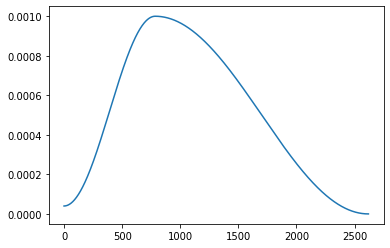

In [31]:
modelfiles = []

modelfiles.append(train_mri_type(df_train, df_valid, 'FLAIR'))